In [28]:
#---- User input-----#
#--------------------#
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
# Experimental values for input
# n=2.46
# n2=1.25*10^-18 m^2/V^2
# wavelength=1.53um
# slab thickness = wavelength
# input amplitude a=1.927*10^8 V/m, time averaged
amp = np.arange(0.007*10**3,1.14*10**3,0.0707*10**3) # amplitude of source
resolution = 90
k = 4.1*10**-6 #4.1*10**-7        # Kerr susceptibility
n=2.46         # index

In [29]:
def nl_cw(amp,resolution,k,n):
    sz = 10          # size of cell in z direction
    dpml = 1        # PML thickness
    time_set_start=3000         # simulation run time start
    time_set=9000-time_set_start         # simulation run time

    #----Continuous Source
    frq_cs=1/1.53          # meep frequency
    cs_width=100          #the inverse of the exponential rate at which the current turns off and on

    # frequency range for monitors
    nfreq = 1
    fmin = 1/1.53
    fmax = 1/1.53

    # Geometry
    d_s=1.53# slab thickness
    pos_s=0# slab position
    
    #################################################################
    # Reference simulation (source only)
    #################################################################
    geometry = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=[] ))]
    geometry2 = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=k ))]

    dimensions = 1
    cell = mp.Vector3(0, 0, sz)
    pml_layers = mp.PML(dpml)
    default_material = mp.Medium(index=1, chi3=[])

    sources = mp.Source(mp.ContinuousSource(frq_cs, width=cs_width), component=mp.Ex,
                        center=mp.Vector3(0, 0, -0.5*sz + dpml), amplitude=amp)

    sim = mp.Simulation(cell_size=cell,
                        geometry=[],
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    sim.run(until=time_set_start)
    trans_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))
    #refl_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
    #                        mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))

    #         Define E field monitor
    dx=1/resolution
    dt=0.5*dx
    tm_val_x=[]
    def get_dot(sim):	
        tm_val_x.append(sim.get_array(size=mp.Vector3(), center=mp.Vector3(0,0,sz/2-dpml), component=mp.Ex))
    #        #        #        #    
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot results

    #         Save reference data
    freqs_ref = mp.get_flux_freqs(trans_ref)
    #plt_range_ref=1/np.asarray(freqs_ref)
    box_x1_trans_ref = mp.get_fluxes(trans_ref)
    flux_ref=np.asarray(box_x1_trans_ref)

    tm_val_x1=np.array(tm_val_x)
    max_ind=np.size(tm_val_x1)
    c=3*10**8 # m/s speed of light
    mon_t=[]
    for n in np.arange(0,max_ind,1):
        mon_tmp=(dt+dt*n)*(10**-6/c)*10**15 # s
        mon_t.append(mon_tmp)

    #################################################################
    # 1d simulation of a plane wave propagating through a linear slab
    #################################################################
    sim.reset_meep()
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    sim.run(until=time_set_start)
    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml + 4)))
    tm_val_x=[]
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot results
    freqs_lin = mp.get_flux_freqs(trans)
    plt_range_lin=1/np.asarray(freqs_lin)
    box_x1_trans_lin = mp.get_fluxes(trans)
    flux_lin=np.asarray(box_x1_trans_lin)
    box_x1_refl_lin = mp.get_fluxes(refl)
    flux_refl_lin=np.asarray(box_x1_refl_lin)

    tm_val_x2=np.array(tm_val_x)

    #################################################################
    # 1d simulation of a plane wave propagating through a Kerr medium
    #################################################################
    sim.reset_meep()
    #geometry = [mp.Block(center=mp.Vector3(0,0,(sz-dpml)/4),size=mp.Vector3(0,0,(sz-dpml)/2), material=mp.Medium(index=n, chi3=k ))]
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry2,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    sim.run(until=time_set_start)
    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml + 4)))
    tm_val_x=[]
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot fluxes
    freqs = mp.get_flux_freqs(trans)
    plt_range=1/np.asarray(freqs)
    box_x1_trans = mp.get_fluxes(trans)
    flux=np.asarray(box_x1_trans)
    box_x1_refl = mp.get_fluxes(refl)
    flux_refl=np.asarray(box_x1_refl)

    tm_val_x3=np.array(tm_val_x)

    figure1=plt.figure(dpi=100)
    ax1=plt.subplot(1, 3, 1)
    plt.plot(mon_t,tm_val_x1/(10**-6))
    plt.ylim(np.amax(tm_val_x1))
    plt.xlabel('time (fs)')
    plt.ylabel('Ex source (V/m)') 
    ax2=plt.subplot(1, 3, 2)
    plt.plot(mon_t,tm_val_x2/(10**-6))
    plt.ylim(np.amax(tm_val_x1))
    plt.xlabel('time (fs)')
    plt.ylabel('Ex linear (V/m)') 
    ax3=plt.subplot(1, 3, 3)
    plt.plot(mon_t,tm_val_x3/(10**-6))
    plt.ylim(np.amax(tm_val_x1))
    plt.xlabel('time (fs)')
    plt.ylabel('Ex nonlinear (V/m)') 

    E_out=np.amax(tm_val_x1)/(10**-6)
    E_out2=np.amax(tm_val_x2)/(10**-6)
    E_out3=np.amax(tm_val_x3)/(10**-6)
    T_nl = flux/flux_ref
    R_nl = (-flux_refl+flux_ref)/flux_ref
    A_nl = 1-(-flux_refl+flux_ref)/flux_ref-flux/flux_ref
    T_l = flux_lin/flux_ref
    R_l = (-flux_refl_lin+flux_ref)/flux_ref
    A_l = 1-(-flux_refl_lin+flux_ref)/flux_ref-flux_lin/flux_ref
    print(E_out)
    print(T_nl)
    print(R_nl)
    print(A_nl)
    print(T_l)
    print(R_l)
    print(A_l)
    print(plt_range)
    return E_out, E_out2, E_out3, plt_range, T_nl, R_nl, A_nl, T_l, R_l, A_l

0
-----------
Initializing structure...
time for choose_chunkdivision = 5.98431e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000224113 s
-----------


FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1821.4666666666667/3000.0 = 60.7% done in 4.0s, 2.6s to go
on time step 328525 (time=1825.14), 1.21757e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 563703 (time=3131.68), 1.70085e-05 s/step
Meep progress: 365.75/9000.0 = 4.1% done in 4.0s, 94.4s to go
on time step 627949 (time=3488.61), 6.22608e-05 s/step
Meep progress: 715.738888888889/9000.0 = 8.0% done in 8.0s, 92.6s to go
on time step 691126 (time=3839.59), 6.33151e-05 s/step
Meep progress: 1070.2833333333333/9000.0 = 11.9% done in 12.0s, 88.9s to go
on time step 754231 (time=4190.17), 6.33874e-05 s/step
Meep progress: 1414.333333333334/9000.0 = 15.7% done in 16.0s, 85.8s to go
on time step 817583 (time=4542.13), 6.314e-05 s/step
Meep progress: 1773.6333333333332/9000.0 = 19.7% done in 20.0s, 81.5s to go
on time step 881843 (time=4899.13), 6.22474e-05 s/step
Meep progress: 2133.9333333333334/9000.0 = 23.7% done in 24.0s, 77.2s to go
on time step 947780 (time=5265.44), 6.0664e-05 s/step
Meep progress: 2493.8/9000.0 = 27.7% done in 28.0s, 73.1s to go
on time step 1007840 (time=5599.11), 6.6601e-05 s/step
Meep progress: 2832.6611111111115/9000.0 = 31.5% done in 32.0s

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1736.3055555555557/3000.0 = 57.9% done in 4.0s, 2.9s to go
on time step 313008 (time=1738.93), 1.27792e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 558378 (time=3102.1), 1.63021e-05 s/step
Meep progress: 351.3944444444446/9000.0 = 3.9% done in 4.0s, 98.4s to go
on time step 620782 (time=3448.79), 6.40987e-05 s/step
Meep progress: 703.1055555555558/9000.0 = 7.8% done in 8.0s, 94.4s to go
on time step 685658 (time=3809.21), 6.16566e-05 s/step
Meep progress: 1073.1111111111113/9000.0 = 11.9% done in 12.0s, 88.6s to go
on time step 752186 (time=4178.81), 6.01254e-05 s/step
Meep progress: 1443.1444444444442/9000.0 = 16.0% done in 16.0s, 83.8s to go
on time step 818353 (time=4546.41), 6.04531e-05 s/step
Meep progress: 1806.3500000000004/9000.0 = 20.1% done in 20.0s, 79.6s to go
on time step 883159 (time=4906.44), 6.17233e-05 s/step
Meep progress: 2160.0444444444447/9000.0 = 24.0% done in 24.0s, 76.0s to go
on time step 946646 (time=5259.14), 6.30053e-05 s/step
Meep progress: 2515.927777777778/9000.0 = 28.0% done in 28.0s, 72.2s to go
on time step 1011885 (time=5621.58), 6.13132e-05 s/step
Meep progress: 2884.9722222222226/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1684.4666666666667/3000.0 = 56.1% done in 4.0s, 3.1s to go
on time step 303609 (time=1686.72), 1.31749e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 551332 (time=3062.96), 1.61472e-05 s/step
Meep progress: 344.7666666666669/9000.0 = 3.8% done in 4.0s, 100.4s to go
on time step 613962 (time=3410.9), 6.38672e-05 s/step
Meep progress: 694.2666666666669/9000.0 = 7.7% done in 8.0s, 95.7s to go
on time step 677106 (time=3761.7), 6.33473e-05 s/step
Meep progress: 1057.25/9000.0 = 11.7% done in 12.0s, 90.2s to go
on time step 742513 (time=4125.07), 6.11563e-05 s/step
Meep progress: 1408.8833333333332/9000.0 = 15.7% done in 16.0s, 86.2s to go
on time step 805059 (time=4472.55), 6.39541e-05 s/step
Meep progress: 1758.227777777778/9000.0 = 19.5% done in 20.0s, 82.4s to go
on time step 868536 (time=4825.2), 6.30158e-05 s/step
Meep progress: 2107.4222222222224/9000.0 = 23.4% done in 24.0s, 78.5s to go
on time step 931324 (time=5174.02), 6.37071e-05 s/step
Meep progress: 2469.133333333333/9000.0 = 27.4% done in 28.0s, 74.1s to go
on time step 996741 (time=5537.45), 6.1147e-05 s/step
Meep progress: 2830.083333333334/9000.0 = 31.4% do

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1789.8055555555557/3000.0 = 59.7% done in 4.0s, 2.7s to go
on time step 322594 (time=1792.19), 1.23995e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 559030 (time=3105.72), 1.6918e-05 s/step
Meep progress: 347.9500000000003/9000.0 = 3.9% done in 4.0s, 99.5s to go
on time step 620573 (time=3447.63), 6.49964e-05 s/step
Meep progress: 676.3333333333335/9000.0 = 7.5% done in 8.0s, 98.5s to go
on time step 680282 (time=3779.34), 6.69919e-05 s/step
Meep progress: 1035.0444444444447/9000.0 = 11.5% done in 12.0s, 92.3s to go
on time step 746802 (time=4148.9), 6.01325e-05 s/step
Meep progress: 1394.0444444444447/9000.0 = 15.5% done in 16.0s, 87.3s to go
on time step 810703 (time=4503.91), 6.25969e-05 s/step
Meep progress: 1757.3111111111111/9000.0 = 19.5% done in 20.0s, 82.4s to go
on time step 875841 (time=4865.78), 6.14086e-05 s/step
Meep progress: 2111.7777777777783/9000.0 = 23.5% done in 24.0s, 78.3s to go
on time step 940700 (time=5226.11), 6.16725e-05 s/step
Meep progress: 2484.3722222222223/9000.0 = 27.6% done in 28.0s, 73.4s to go
on time step 1007614 (time=5597.86), 5.97783e-05 s/step
Meep progress: 2855.7444444444445/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1718.1833333333334/3000.0 = 57.3% done in 4.0s, 3.0s to go
on time step 309613 (time=1720.07), 1.29194e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 557202 (time=3095.57), 1.6156e-05 s/step
Meep progress: 360.5055555555555/9000.0 = 4.0% done in 4.0s, 95.9s to go
on time step 620970 (time=3449.83), 6.2728e-05 s/step
Meep progress: 718.1222222222223/9000.0 = 8.0% done in 8.0s, 92.3s to go
on time step 686635 (time=3814.64), 6.09158e-05 s/step
Meep progress: 1060.6833333333334/9000.0 = 11.8% done in 12.0s, 89.8s to go
on time step 745975 (time=4144.31), 6.74085e-05 s/step
Meep progress: 1398.7555555555555/9000.0 = 15.5% done in 16.0s, 87.0s to go
on time step 806771 (time=4482.06), 6.57944e-05 s/step
Meep progress: 1744.5333333333338/9000.0 = 19.4% done in 20.0s, 83.2s to go
on time step 871869 (time=4843.72), 6.14461e-05 s/step
Meep progress: 2105.855555555556/9000.0 = 23.4% done in 24.0s, 78.6s to go
on time step 937111 (time=5206.17), 6.13116e-05 s/step
Meep progress: 2474.7777777777783/9000.0 = 27.5% done in 28.0s, 73.8s to go
on time step 1003090 (time=5572.72), 6.06257e-05 s/step
Meep progress: 2813.666666666667/900

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1720.9388888888889/3000.0 = 57.4% done in 4.0s, 3.0s to go
on time step 310178 (time=1723.21), 1.28959e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 555398 (time=3085.54), 1.63121e-05 s/step
Meep progress: 352.0/9000.0 = 3.9% done in 4.0s, 98.3s to go
on time step 618680 (time=3437.11), 6.32092e-05 s/step
Meep progress: 710.7944444444447/9000.0 = 7.9% done in 8.0s, 93.3s to go
on time step 683562 (time=3797.57), 6.16506e-05 s/step
Meep progress: 1075.1111111111113/9000.0 = 11.9% done in 12.0s, 88.5s to go
on time step 748860 (time=4160.33), 6.12578e-05 s/step
Meep progress: 1434.8666666666668/9000.0 = 15.9% done in 16.0s, 84.4s to go
on time step 813200 (time=4517.78), 6.217e-05 s/step
Meep progress: 1785.7333333333336/9000.0 = 19.8% done in 20.0s, 80.8s to go
on time step 876746 (time=4870.81), 6.29466e-05 s/step
Meep progress: 2146.3166666666666/9000.0 = 23.8% done in 24.0s, 76.6s to go
on time step 941831 (time=5232.39), 6.14585e-05 s/step
Meep progress: 2496.966666666667/9000.0 = 27.7% done in 28.0s, 72.9s to go
on time step 1003676 (time=5575.98), 6.46785e-05 s/step
Meep progress: 2847.083333333334/9000.0 = 31.6% 

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1848.2611111111112/3000.0 = 61.6% done in 4.0s, 2.5s to go
on time step 333095 (time=1850.53), 1.20086e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 566101 (time=3145.01), 1.7167e-05 s/step
Meep progress: 381.52222222222235/9000.0 = 4.2% done in 4.0s, 90.4s to go
on time step 634693 (time=3526.07), 5.83164e-05 s/step
Meep progress: 761.7166666666667/9000.0 = 8.5% done in 8.0s, 86.5s to go
on time step 702489 (time=3902.72), 5.90009e-05 s/step
Meep progress: 1132.0666666666666/9000.0 = 12.6% done in 12.0s, 83.4s to go
on time step 769185 (time=4273.25), 5.99739e-05 s/step
Meep progress: 1499.094444444445/9000.0 = 16.7% done in 16.0s, 80.1s to go
on time step 834618 (time=4636.77), 6.11316e-05 s/step
Meep progress: 1869.344444444445/9000.0 = 20.8% done in 20.0s, 76.3s to go
on time step 902102 (time=5011.68), 5.9274e-05 s/step
Meep progress: 2245.572222222222/9000.0 = 25.0% done in 24.0s, 72.2s to go
on time step 969706 (time=5387.26), 5.91687e-05 s/step
Meep progress: 2620.5555555555557/9000.0 = 29.1% done in 28.0s, 68.2s to go
on time step 1036581 (time=5758.78), 5.98137e-05 s/step
Meep progress: 2989.5333333333338/900

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1806.5500000000002/3000.0 = 60.2% done in 4.0s, 2.6s to go
on time step 325588 (time=1808.82), 1.22855e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 561310 (time=3118.39), 1.69693e-05 s/step
Meep progress: 370.1166666666668/9000.0 = 4.1% done in 4.0s, 93.3s to go
on time step 628296 (time=3490.53), 5.97146e-05 s/step
Meep progress: 741.8444444444444/9000.0 = 8.2% done in 8.0s, 89.1s to go
on time step 691956 (time=3844.2), 6.28348e-05 s/step
Meep progress: 1068.0500000000002/9000.0 = 11.9% done in 12.0s, 89.1s to go
on time step 753086 (time=4183.81), 6.54354e-05 s/step
Meep progress: 1425.3722222222223/9000.0 = 15.8% done in 16.0s, 85.0s to go
on time step 817302 (time=4540.57), 6.22906e-05 s/step
Meep progress: 1777.4555555555553/9000.0 = 19.7% done in 20.0s, 81.3s to go
on time step 880580 (time=4892.11), 6.32134e-05 s/step
Meep progress: 2140.5/9000.0 = 23.8% done in 24.0s, 76.9s to go
on time step 946209 (time=5256.72), 6.09488e-05 s/step
Meep progress: 2507.5/9000.0 = 27.9% done in 28.0s, 72.5s to go
on time step 1013137 (time=5628.54), 5.97668e-05 s/step
Meep progress: 2867.7222222222226/9000.0 = 31.9% done in 3

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1693.8722222222223/3000.0 = 56.5% done in 4.0s, 3.1s to go
on time step 305394 (time=1696.63), 1.30979e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 553727 (time=3076.26), 1.61074e-05 s/step
Meep progress: 357.9500000000003/9000.0 = 4.0% done in 4.0s, 96.6s to go
on time step 618368 (time=3435.38), 6.18804e-05 s/step
Meep progress: 718.2333333333336/9000.0 = 8.0% done in 8.0s, 92.2s to go
on time step 683521 (time=3797.34), 6.13944e-05 s/step
Meep progress: 1079.4/9000.0 = 12.0% done in 12.0s, 88.1s to go
on time step 747801 (time=4154.45), 6.22281e-05 s/step
Meep progress: 1424.9722222222226/9000.0 = 15.8% done in 16.0s, 85.1s to go
on time step 810412 (time=4502.29), 6.38868e-05 s/step
Meep progress: 1785.2166666666672/9000.0 = 19.8% done in 20.0s, 80.8s to go
on time step 874611 (time=4858.95), 6.23071e-05 s/step
Meep progress: 2134.822222222222/9000.0 = 23.7% done in 24.0s, 77.2s to go
on time step 938800 (time=5215.56), 6.23166e-05 s/step
Meep progress: 2508.1722222222224/9000.0 = 27.9% done in 28.0s, 72.5s to go
on time step 1005925 (time=5588.47), 5.95903e-05 s/step
Meep progress: 2877.383333333333/9000.0 = 32.0

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1811.2833333333333/3000.0 = 60.4% done in 4.0s, 2.6s to go
on time step 326435 (time=1813.53), 1.22542e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 564033 (time=3133.52), 1.68353e-05 s/step
Meep progress: 377.5666666666666/9000.0 = 4.2% done in 4.0s, 91.3s to go
on time step 631288 (time=3507.16), 5.94756e-05 s/step
Meep progress: 751.8111111111111/9000.0 = 8.4% done in 8.0s, 87.8s to go
on time step 699353 (time=3885.29), 5.87678e-05 s/step
Meep progress: 1133.2722222222228/9000.0 = 12.6% done in 12.0s, 83.3s to go
on time step 767922 (time=4266.23), 5.83355e-05 s/step
Meep progress: 1504.5666666666666/9000.0 = 16.7% done in 16.0s, 79.7s to go
on time step 834624 (time=4636.8), 5.99689e-05 s/step
Meep progress: 1883.0666666666666/9000.0 = 20.9% done in 20.0s, 75.6s to go
on time step 902619 (time=5014.55), 5.88284e-05 s/step
Meep progress: 2261.416666666667/9000.0 = 25.1% done in 24.0s, 71.5s to go
on time step 970870 (time=5393.72), 5.86081e-05 s/step
Meep progress: 2642.572222222222/9000.0 = 29.4% done in 28.0s, 67.4s to go
on time step 1039638 (time=5775.77), 5.81669e-05 s/step
Meep progress: 3022.844444444445/900

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1808.1611111111113/3000.0 = 60.3% done in 4.0s, 2.6s to go
on time step 325941 (time=1810.78), 1.22722e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 562580 (time=3125.44), 1.69034e-05 s/step
Meep progress: 373.8333333333335/9000.0 = 4.2% done in 4.0s, 92.3s to go
on time step 629615 (time=3497.86), 5.96711e-05 s/step
Meep progress: 745.238888888889/9000.0 = 8.3% done in 8.0s, 88.6s to go
on time step 696788 (time=3871.04), 5.95486e-05 s/step
Meep progress: 1119.1999999999998/9000.0 = 12.4% done in 12.0s, 84.5s to go
on time step 762879 (time=4238.22), 6.05229e-05 s/step
Meep progress: 1479.8777777777777/9000.0 = 16.4% done in 16.0s, 81.3s to go
on time step 828944 (time=4605.24), 6.0547e-05 s/step
Meep progress: 1855.1222222222223/9000.0 = 20.6% done in 20.0s, 77.0s to go
on time step 896788 (time=4982.16), 5.89598e-05 s/step
Meep progress: 2233.344444444445/9000.0 = 24.8% done in 24.0s, 72.7s to go
on time step 964916 (time=5360.64), 5.87134e-05 s/step
Meep progress: 2611.522222222223/9000.0 = 29.0% done in 28.0s, 68.5s to go
on time step 1032883 (time=5738.24), 5.88524e-05 s/step
Meep progress: 2984.2444444444445/900

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1748.1833333333334/3000.0 = 58.3% done in 4.0s, 2.9s to go
on time step 315085 (time=1750.47), 1.2695e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 557032 (time=3094.62), 1.65328e-05 s/step
Meep progress: 366.327777777778/9000.0 = 4.1% done in 4.0s, 94.3s to go
on time step 623451 (time=3463.62), 6.02245e-05 s/step
Meep progress: 728.4555555555557/9000.0 = 8.1% done in 8.0s, 90.8s to go
on time step 688240 (time=3823.56), 6.17396e-05 s/step
Meep progress: 1102.0222222222228/9000.0 = 12.2% done in 12.0s, 86.0s to go
on time step 755689 (time=4198.27), 5.93042e-05 s/step
Meep progress: 1470.4444444444443/9000.0 = 16.3% done in 16.0s, 81.9s to go
on time step 821845 (time=4565.81), 6.04639e-05 s/step
Meep progress: 1827.4444444444443/9000.0 = 20.3% done in 20.0s, 78.5s to go
on time step 886484 (time=4924.91), 6.18826e-05 s/step
Meep progress: 2196.8166666666666/9000.0 = 24.4% done in 24.0s, 74.3s to go
on time step 952838 (time=5293.54), 6.0283e-05 s/step
Meep progress: 2564.311111111111/9000.0 = 28.5% done in 28.0s, 70.3s to go
on time step 1019612 (time=5664.51), 5.99039e-05 s/step
Meep progress: 2948.75/9000.0 = 32.8

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1922.361111111111/3000.0 = 64.1% done in 4.0s, 2.2s to go
on time step 346406 (time=1924.48), 1.15472e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 571348 (time=3174.16), 1.77825e-05 s/step
Meep progress: 395.65555555555557/9000.0 = 4.4% done in 4.0s, 87.0s to go
on time step 643267 (time=3573.71), 5.56184e-05 s/step
Meep progress: 795.3444444444444/9000.0 = 8.8% done in 8.0s, 82.5s to go
on time step 714906 (time=3971.7), 5.58358e-05 s/step
Meep progress: 1193.8277777777776/9000.0 = 13.3% done in 12.0s, 78.5s to go
on time step 785832 (time=4365.73), 5.63973e-05 s/step
Meep progress: 1582.9722222222226/9000.0 = 17.6% done in 16.0s, 75.0s to go
on time step 856335 (time=4757.42), 5.67359e-05 s/step
Meep progress: 1976.2666666666664/9000.0 = 22.0% done in 20.0s, 71.1s to go
on time step 927679 (time=5153.77), 5.60667e-05 s/step
Meep progress: 2369.7222222222226/9000.0 = 26.3% done in 24.0s, 67.2s to go
on time step 998488 (time=5547.16), 5.64907e-05 s/step
Meep progress: 2769.95/9000.0 = 30.8% done in 28.0s, 63.0s to go
on time step 1070411 (time=5946.73), 5.56152e-05 s/step
Meep progress: 3165.8055555555557/9000.0 = 3

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1847.7777777777778/3000.0 = 61.6% done in 4.0s, 2.5s to go
on time step 334473 (time=1858.18), 1.19591e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 565693 (time=3142.74), 1.72996e-05 s/step
Meep progress: 373.9500000000003/9000.0 = 4.2% done in 4.0s, 92.3s to go
on time step 632951 (time=3516.39), 5.94726e-05 s/step
Meep progress: 750.6111111111113/9000.0 = 8.3% done in 8.0s, 87.9s to go
on time step 701138 (time=3895.21), 5.86627e-05 s/step
Meep progress: 1129.3111111111111/9000.0 = 12.5% done in 12.0s, 83.6s to go
on time step 767873 (time=4265.96), 5.99394e-05 s/step
Meep progress: 1488.405555555556/9000.0 = 16.5% done in 16.0s, 80.7s to go
on time step 833764 (time=4632.02), 6.07071e-05 s/step
Meep progress: 1863.2944444444447/9000.0 = 20.7% done in 20.0s, 76.6s to go
on time step 901220 (time=5006.78), 5.92987e-05 s/step
Meep progress: 2238.177777777778/9000.0 = 24.9% done in 24.0s, 72.5s to go
on time step 968896 (time=5382.76), 5.91061e-05 s/step
Meep progress: 2616.738888888889/9000.0 = 29.1% done in 28.0s, 68.3s to go
on time step 1037042 (time=5761.34), 5.86977e-05 s/step
Meep progress: 2994.905555555556/900

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1762.15/3000.0 = 58.7% done in 4.0s, 2.8s to go
on time step 317622 (time=1764.57), 1.25936e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 560066 (time=3111.48), 1.64987e-05 s/step
Meep progress: 370.7611111111114/9000.0 = 4.1% done in 4.0s, 93.1s to go
on time step 626572 (time=3480.96), 6.01456e-05 s/step
Meep progress: 739.9722222222222/9000.0 = 8.2% done in 8.0s, 89.3s to go
on time step 693188 (time=3851.04), 6.00462e-05 s/step
Meep progress: 1112.5333333333338/9000.0 = 12.4% done in 12.0s, 85.1s to go
on time step 760197 (time=4223.32), 5.96937e-05 s/step
Meep progress: 1484.9611111111117/9000.0 = 16.5% done in 16.0s, 81.0s to go
on time step 826562 (time=4592.01), 6.02728e-05 s/step
Meep progress: 1840.6222222222223/9000.0 = 20.5% done in 20.0s, 77.8s to go
on time step 891234 (time=4951.3), 6.18509e-05 s/step
Meep progress: 2209.2555555555555/9000.0 = 24.5% done in 24.0s, 73.8s to go
on time step 957833 (time=5321.29), 6.00614e-05 s/step
Meep progress: 2582.916666666667/9000.0 = 28.7% done in 28.0s, 69.6s to go
on time step 1025089 (time=5694.94), 5.94745e-05 s/step
Meep progress: 2955.438888888889/90

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1866.3333333333335/3000.0 = 62.2% done in 4.0s, 2.4s to go
on time step 336365 (time=1868.69), 1.18927e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 563940 (time=3133), 1.75767e-05 s/step
Meep progress: 378.2611111111114/9000.0 = 4.2% done in 4.0s, 91.2s to go
on time step 631788 (time=3509.93), 5.89557e-05 s/step
Meep progress: 751.3944444444446/9000.0 = 8.3% done in 8.0s, 87.8s to go
on time step 699416 (time=3885.64), 5.91472e-05 s/step
Meep progress: 1131.1500000000005/9000.0 = 12.6% done in 12.0s, 83.5s to go
on time step 767770 (time=4265.39), 5.85192e-05 s/step
Meep progress: 1509.9722222222226/9000.0 = 16.8% done in 16.0s, 79.4s to go
on time step 835956 (time=4644.2), 5.86639e-05 s/step
Meep progress: 1889.5388888888892/9000.0 = 21.0% done in 20.0s, 75.3s to go
on time step 903970 (time=5022.06), 5.88122e-05 s/step
Meep progress: 2263.3388888888894/9000.0 = 25.1% done in 24.0s, 71.4s to go
on time step 971312 (time=5396.18), 5.93986e-05 s/step
Meep progress: 2630.1611111111115/9000.0 = 29.2% done in 28.0s, 67.8s to go
on time step 1036177 (time=5756.54), 6.16669e-05 s/step
Meep progress: 3001.188888888889/9000

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1871.25/3000.0 = 62.4% done in 4.0s, 2.4s to go
on time step 337183 (time=1873.24), 1.1863e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 563322 (time=3129.57), 1.76884e-05 s/step
Meep progress: 356.5444444444447/9000.0 = 4.0% done in 4.0s, 97.0s to go
on time step 630283 (time=3501.57), 5.97374e-05 s/step
Meep progress: 727.4611111111112/9000.0 = 8.1% done in 8.0s, 91.0s to go
on time step 696448 (time=3869.16), 6.04551e-05 s/step
Meep progress: 1090.8222222222225/9000.0 = 12.1% done in 12.0s, 87.0s to go
on time step 762945 (time=4238.58), 6.01532e-05 s/step
Meep progress: 1468.0388888888892/9000.0 = 16.3% done in 16.0s, 82.1s to go
on time step 830414 (time=4613.41), 5.92872e-05 s/step
Meep progress: 1842.1000000000004/9000.0 = 20.5% done in 20.0s, 77.7s to go
on time step 898056 (time=4989.2), 5.91354e-05 s/step
Meep progress: 2215.011111111111/9000.0 = 24.6% done in 24.0s, 73.5s to go
on time step 963796 (time=5354.42), 6.08458e-05 s/step
Meep progress: 2574.8055555555557/9000.0 = 28.6% done in 28.0s, 69.9s to go
on time step 1030201 (time=5723.34), 6.02371e-05 s/step
Meep progress: 2951.7944444444447/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1799.0166666666667/3000.0 = 60.0% done in 4.0s, 2.7s to go
on time step 324316 (time=1801.76), 1.23337e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 560858 (time=3115.88), 1.69104e-05 s/step
Meep progress: 355.45555555555575/9000.0 = 3.9% done in 4.0s, 97.3s to go
on time step 625622 (time=3475.68), 6.17638e-05 s/step
Meep progress: 722.7666666666669/9000.0 = 8.0% done in 8.0s, 91.6s to go
on time step 692074 (time=3844.86), 6.01945e-05 s/step
Meep progress: 1092.327777777778/9000.0 = 12.1% done in 12.0s, 86.9s to go
on time step 758514 (time=4213.97), 6.02056e-05 s/step
Meep progress: 1464.822222222222/9000.0 = 16.3% done in 16.0s, 82.3s to go
on time step 825629 (time=4586.83), 5.95993e-05 s/step
Meep progress: 1837.3888888888887/9000.0 = 20.4% done in 20.0s, 78.0s to go
on time step 892631 (time=4959.06), 5.96998e-05 s/step
Meep progress: 2206.1722222222224/9000.0 = 24.5% done in 24.0s, 73.9s to go
on time step 957815 (time=5321.19), 6.13651e-05 s/step
Meep progress: 2561.2222222222226/9000.0 = 28.5% done in 28.0s, 70.4s to go
on time step 1022928 (time=5682.93), 6.14323e-05 s/step
Meep progress: 2933.488888888889/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1861.0666666666668/3000.0 = 62.0% done in 4.0s, 2.4s to go
on time step 335400 (time=1863.33), 1.19261e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 566788 (time=3148.82), 1.72872e-05 s/step
Meep progress: 377.82222222222254/9000.0 = 4.2% done in 4.0s, 91.3s to go
on time step 634555 (time=3525.31), 5.9026e-05 s/step
Meep progress: 752.3166666666666/9000.0 = 8.4% done in 8.0s, 87.7s to go
on time step 702369 (time=3902.05), 5.89851e-05 s/step
Meep progress: 1132.1611111111115/9000.0 = 12.6% done in 12.0s, 83.4s to go
on time step 768986 (time=4272.14), 6.00461e-05 s/step
Meep progress: 1493.9000000000005/9000.0 = 16.6% done in 16.0s, 80.4s to go
on time step 835877 (time=4643.76), 5.97994e-05 s/step
Meep progress: 1872.2833333333338/9000.0 = 20.8% done in 20.0s, 76.1s to go
on time step 903688 (time=5020.49), 5.89877e-05 s/step
Meep progress: 2246.6000000000004/9000.0 = 25.0% done in 24.0s, 72.1s to go
on time step 970570 (time=5392.06), 5.98069e-05 s/step
Meep progress: 2620.772222222223/9000.0 = 29.1% done in 28.0s, 68.2s to go
on time step 1038631 (time=5770.17), 5.87714e-05 s/step
Meep progress: 2998.261111111111/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1864.1444444444446/3000.0 = 62.1% done in 4.0s, 2.4s to go
on time step 335920 (time=1866.22), 1.19076e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 565872 (time=3143.73), 1.7395e-05 s/step
Meep progress: 374.13333333333367/9000.0 = 4.2% done in 4.0s, 92.2s to go
on time step 633171 (time=3517.62), 5.94365e-05 s/step
Meep progress: 744.5833333333335/9000.0 = 8.3% done in 8.0s, 88.7s to go
on time step 700371 (time=3890.95), 5.95239e-05 s/step
Meep progress: 1122.4833333333336/9000.0 = 12.5% done in 12.0s, 84.2s to go
on time step 768412 (time=4268.96), 5.87888e-05 s/step
Meep progress: 1484.7111111111117/9000.0 = 16.5% done in 16.0s, 81.0s to go
on time step 833441 (time=4630.23), 6.1512e-05 s/step
Meep progress: 1858.7055555555553/9000.0 = 20.7% done in 20.0s, 76.8s to go
on time step 900631 (time=5003.51), 5.95335e-05 s/step
Meep progress: 2227.927777777778/9000.0 = 24.8% done in 24.0s, 73.0s to go
on time step 966932 (time=5371.84), 6.03309e-05 s/step
Meep progress: 2601.727777777778/9000.0 = 28.9% done in 28.0s, 68.9s to go
on time step 1034612 (time=5747.84), 5.91017e-05 s/step
Meep progress: 2978.0888888888894/90

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1716.8500000000001/3000.0 = 57.2% done in 4.0s, 3.0s to go
on time step 309547 (time=1719.71), 1.29221e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 558468 (time=3102.6), 1.60694e-05 s/step
Meep progress: 371.15555555555557/9000.0 = 4.1% done in 4.0s, 93.0s to go
on time step 625312 (time=3473.96), 5.98412e-05 s/step
Meep progress: 739.0500000000002/9000.0 = 8.2% done in 8.0s, 89.4s to go
on time step 691460 (time=3841.44), 6.04717e-05 s/step
Meep progress: 1110.738888888889/9000.0 = 12.3% done in 12.0s, 85.2s to go
on time step 758659 (time=4214.77), 5.95251e-05 s/step
Meep progress: 1483.3111111111111/9000.0 = 16.5% done in 16.0s, 81.1s to go
on time step 825718 (time=4587.32), 5.96495e-05 s/step
Meep progress: 1855.3500000000004/9000.0 = 20.6% done in 20.0s, 77.0s to go
on time step 891666 (time=4953.7), 6.06541e-05 s/step
Meep progress: 2205.616666666667/9000.0 = 24.5% done in 24.0s, 73.9s to go
on time step 955557 (time=5308.65), 6.26069e-05 s/step
Meep progress: 2573.9444444444443/9000.0 = 28.6% done in 28.0s, 69.9s to go
on time step 1022061 (time=5678.12), 6.01469e-05 s/step
Meep progress: 2947.0444444444447/90

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1873.8777777777777/3000.0 = 62.5% done in 4.0s, 2.4s to go
on time step 337722 (time=1876.23), 1.18441e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 566483 (time=3147.13), 1.74857e-05 s/step
Meep progress: 358.7666666666669/9000.0 = 4.0% done in 4.0s, 96.3s to go
on time step 631929 (time=3510.72), 6.11193e-05 s/step
Meep progress: 734.5277777777778/9000.0 = 8.2% done in 8.0s, 90.0s to go
on time step 699426 (time=3885.7), 5.92627e-05 s/step
Meep progress: 1111.8388888888894/9000.0 = 12.4% done in 12.0s, 85.1s to go
on time step 767786 (time=4265.48), 5.85142e-05 s/step
Meep progress: 1492.261111111111/9000.0 = 16.6% done in 16.0s, 80.5s to go
on time step 836206 (time=4645.59), 5.84631e-05 s/step
Meep progress: 1872.0055555555555/9000.0 = 20.8% done in 20.0s, 76.2s to go
on time step 904592 (time=5025.51), 5.84916e-05 s/step
Meep progress: 2247.0333333333338/9000.0 = 25.0% done in 24.0s, 72.1s to go
on time step 969935 (time=5388.53), 6.12156e-05 s/step
Meep progress: 2611.4833333333336/9000.0 = 29.0% done in 28.0s, 68.5s to go
on time step 1037564 (time=5764.24), 5.9147e-05 s/step
Meep progress: 2990.844444444445/900

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1862.3722222222223/3000.0 = 62.1% done in 4.0s, 2.4s to go
on time step 335627 (time=1864.59), 1.1918e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 563877 (time=3132.65), 1.75253e-05 s/step
Meep progress: 359.18888888888887/9000.0 = 4.0% done in 4.0s, 96.2s to go
on time step 630193 (time=3501.07), 6.03174e-05 s/step
Meep progress: 733.5166666666669/9000.0 = 8.2% done in 8.0s, 90.2s to go
on time step 697529 (time=3875.16), 5.94041e-05 s/step
Meep progress: 1111.572222222222/9000.0 = 12.4% done in 12.0s, 85.2s to go
on time step 765992 (time=4255.51), 5.84262e-05 s/step
Meep progress: 1490.583333333334/9000.0 = 16.6% done in 16.0s, 80.6s to go
on time step 834081 (time=4633.78), 5.87469e-05 s/step
Meep progress: 1867.7833333333338/9000.0 = 20.8% done in 20.0s, 76.4s to go
on time step 902054 (time=5011.41), 5.88476e-05 s/step
Meep progress: 2245.6000000000004/9000.0 = 25.0% done in 24.0s, 72.2s to go
on time step 969668 (time=5387.04), 5.91605e-05 s/step
Meep progress: 2617.5166666666673/9000.0 = 29.1% done in 28.0s, 68.3s to go
on time step 1036981 (time=5761.01), 5.94251e-05 s/step
Meep progress: 2993.9444444444443/

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1742.5777777777778/3000.0 = 58.1% done in 4.0s, 2.9s to go
on time step 313949 (time=1744.16), 1.2741e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 559513 (time=3108.41), 1.62892e-05 s/step
Meep progress: 373.4333333333334/9000.0 = 4.1% done in 4.0s, 92.4s to go
on time step 626965 (time=3483.14), 5.93015e-05 s/step
Meep progress: 743.9222222222224/9000.0 = 8.3% done in 8.0s, 88.8s to go
on time step 693117 (time=3850.65), 6.04674e-05 s/step
Meep progress: 1112.9722222222226/9000.0 = 12.4% done in 12.0s, 85.0s to go
on time step 760086 (time=4222.7), 5.97294e-05 s/step
Meep progress: 1488.072222222222/9000.0 = 16.5% done in 16.0s, 80.8s to go
on time step 827530 (time=4597.39), 5.93085e-05 s/step
Meep progress: 1859.0166666666664/9000.0 = 20.7% done in 20.0s, 76.8s to go
on time step 894307 (time=4968.37), 5.9901e-05 s/step
Meep progress: 2234.1388888888887/9000.0 = 24.8% done in 24.0s, 72.7s to go
on time step 961766 (time=5343.14), 5.92956e-05 s/step
Meep progress: 2603.0277777777783/9000.0 = 28.9% done in 28.0s, 68.8s to go
on time step 1028253 (time=5712.52), 6.01625e-05 s/step
Meep progress: 2976.822222222222/900

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1802.7722222222224/3000.0 = 60.1% done in 4.0s, 2.7s to go
on time step 324965 (time=1805.36), 1.2309e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 564770 (time=3137.61), 1.66804e-05 s/step
Meep progress: 382.0111111111114/9000.0 = 4.2% done in 4.0s, 90.2s to go
on time step 633558 (time=3519.77), 5.81502e-05 s/step
Meep progress: 760.911111111111/9000.0 = 8.5% done in 8.0s, 86.6s to go
on time step 701669 (time=3898.16), 5.87282e-05 s/step
Meep progress: 1139.227777777778/9000.0 = 12.7% done in 12.0s, 82.8s to go
on time step 769889 (time=4277.16), 5.86339e-05 s/step
Meep progress: 1521.227777777778/9000.0 = 16.9% done in 16.0s, 78.7s to go
on time step 837331 (time=4651.84), 5.93109e-05 s/step
Meep progress: 1887.8500000000004/9000.0 = 21.0% done in 20.0s, 75.3s to go
on time step 904670 (time=5025.94), 5.9401e-05 s/step
Meep progress: 2269.761111111111/9000.0 = 25.2% done in 24.0s, 71.2s to go
on time step 973347 (time=5407.48), 5.82439e-05 s/step
Meep progress: 2647.955555555556/9000.0 = 29.4% done in 28.0s, 67.2s to go
on time step 1041432 (time=5785.73), 5.87508e-05 s/step
Meep progress: 3027.2555555555555/9000.

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1780.1666666666667/3000.0 = 59.3% done in 4.0s, 2.7s to go
on time step 320942 (time=1783.01), 1.24633e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 562790 (time=3126.61), 1.65394e-05 s/step
Meep progress: 376.5444444444447/9000.0 = 4.2% done in 4.0s, 91.6s to go
on time step 631003 (time=3505.57), 5.86411e-05 s/step
Meep progress: 753.488888888889/9000.0 = 8.4% done in 8.0s, 87.6s to go
on time step 698492 (time=3880.51), 5.92693e-05 s/step
Meep progress: 1127.2666666666664/9000.0 = 12.5% done in 12.0s, 83.8s to go
on time step 766140 (time=4256.33), 5.91296e-05 s/step
Meep progress: 1506.9444444444443/9000.0 = 16.7% done in 16.0s, 79.6s to go
on time step 834274 (time=4634.86), 5.87081e-05 s/step
Meep progress: 1868.2777777777783/9000.0 = 20.8% done in 20.0s, 76.3s to go
on time step 899518 (time=4997.32), 6.13084e-05 s/step
Meep progress: 2246.1222222222223/9000.0 = 25.0% done in 24.0s, 72.2s to go
on time step 967143 (time=5373.02), 5.91505e-05 s/step
Meep progress: 2618.3388888888894/9000.0 = 29.1% done in 28.0s, 68.2s to go
on time step 1034207 (time=5745.59), 5.96454e-05 s/step
Meep progress: 2995.1500000000005/

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1769.5277777777778/3000.0 = 59.0% done in 4.0s, 2.8s to go
on time step 318976 (time=1772.09), 1.25401e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 560906 (time=3116.14), 1.65338e-05 s/step
Meep progress: 356.3611111111113/9000.0 = 4.0% done in 4.0s, 97.0s to go
on time step 625194 (time=3473.3), 6.22207e-05 s/step
Meep progress: 731.9722222222222/9000.0 = 8.1% done in 8.0s, 90.4s to go
on time step 692487 (time=3847.15), 5.94424e-05 s/step
Meep progress: 1102.7777777777783/9000.0 = 12.3% done in 12.0s, 85.9s to go
on time step 759513 (time=4219.52), 5.96795e-05 s/step
Meep progress: 1479.3722222222223/9000.0 = 16.4% done in 16.0s, 81.3s to go
on time step 827380 (time=4596.56), 5.89395e-05 s/step
Meep progress: 1854.6500000000005/9000.0 = 20.6% done in 20.0s, 77.1s to go
on time step 894828 (time=4971.27), 5.93053e-05 s/step
Meep progress: 2229.355555555556/9000.0 = 24.8% done in 24.0s, 72.9s to go
on time step 962327 (time=5346.26), 5.92605e-05 s/step
Meep progress: 2594.333333333334/9000.0 = 28.8% done in 28.0s, 69.1s to go
on time step 1027054 (time=5705.86), 6.17981e-05 s/step
Meep progress: 2960.772222222223/900

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1856.361111111111/3000.0 = 61.9% done in 4.0s, 2.5s to go
on time step 334632 (time=1859.07), 1.19534e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 567404 (time=3152.24), 1.71844e-05 s/step
Meep progress: 381.1944444444448/9000.0 = 4.2% done in 4.0s, 90.4s to go
on time step 635535 (time=3530.75), 5.87105e-05 s/step
Meep progress: 743.2000000000003/9000.0 = 8.3% done in 8.0s, 88.9s to go
on time step 700918 (time=3893.99), 6.11786e-05 s/step
Meep progress: 1120.6999999999998/9000.0 = 12.5% done in 12.0s, 84.4s to go
on time step 768746 (time=4270.81), 5.89735e-05 s/step
Meep progress: 1499.4388888888889/9000.0 = 16.7% done in 16.0s, 80.0s to go
on time step 837448 (time=4652.49), 5.82229e-05 s/step
Meep progress: 1881.3055555555557/9000.0 = 20.9% done in 20.0s, 75.7s to go
on time step 906134 (time=5034.08), 5.82361e-05 s/step
Meep progress: 2262.511111111111/9000.0 = 25.1% done in 24.0s, 71.5s to go
on time step 974638 (time=5414.66), 5.8391e-05 s/step
Meep progress: 2643.3777777777777/9000.0 = 29.4% done in 28.0s, 67.3s to go
on time step 1042838 (time=5793.54), 5.86513e-05 s/step
Meep progress: 3015.3611111111113/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1847.8666666666668/3000.0 = 61.6% done in 4.0s, 2.5s to go
on time step 333050 (time=1850.28), 1.20102e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 565692 (time=3142.73), 1.7194e-05 s/step
Meep progress: 375.9611111111112/9000.0 = 4.2% done in 4.0s, 91.8s to go
on time step 632858 (time=3515.88), 5.95545e-05 s/step
Meep progress: 738.1833333333334/9000.0 = 8.2% done in 8.0s, 89.5s to go
on time step 698435 (time=3880.19), 6.09985e-05 s/step
Meep progress: 1112.5611111111111/9000.0 = 12.4% done in 12.0s, 85.1s to go
on time step 765781 (time=4254.34), 5.93954e-05 s/step
Meep progress: 1489.6944444444443/9000.0 = 16.6% done in 16.0s, 80.7s to go
on time step 834005 (time=4633.36), 5.86307e-05 s/step
Meep progress: 1865.0777777777776/9000.0 = 20.7% done in 20.0s, 76.5s to go
on time step 901255 (time=5006.97), 5.94797e-05 s/step
Meep progress: 2241.3166666666666/9000.0 = 24.9% done in 24.0s, 72.4s to go
on time step 969258 (time=5384.77), 5.88213e-05 s/step
Meep progress: 2618.6500000000005/9000.0 = 29.1% done in 28.0s, 68.2s to go
on time step 1035734 (time=5754.08), 6.01723e-05 s/step
Meep progress: 2973.7777777777783/

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1633.15/3000.0 = 54.4% done in 4.0s, 3.3s to go
on time step 294303 (time=1635.02), 1.35915e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 549016 (time=3050.09), 1.5704e-05 s/step
Meep progress: 354.4000000000001/9000.0 = 3.9% done in 4.0s, 97.6s to go
on time step 613370 (time=3407.61), 6.21569e-05 s/step
Meep progress: 713.1777777777779/9000.0 = 7.9% done in 8.0s, 93.0s to go
on time step 677476 (time=3763.76), 6.23969e-05 s/step
Meep progress: 1060.8777777777777/9000.0 = 11.8% done in 12.0s, 89.8s to go
on time step 740503 (time=4113.91), 6.3465e-05 s/step
Meep progress: 1415.9333333333334/9000.0 = 15.7% done in 16.0s, 85.7s to go
on time step 804841 (time=4471.34), 6.21718e-05 s/step
Meep progress: 1783.1000000000004/9000.0 = 19.8% done in 20.0s, 80.9s to go
on time step 870400 (time=4835.56), 6.10138e-05 s/step
Meep progress: 2144.2666666666664/9000.0 = 23.8% done in 24.0s, 76.7s to go
on time step 935681 (time=5198.23), 6.12738e-05 s/step
Meep progress: 2501.833333333334/9000.0 = 27.8% done in 28.0s, 72.7s to go
on time step 1000002 (time=5555.57), 6.21888e-05 s/step
Meep progress: 2854.6111111111113/90

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1860.7055555555555/3000.0 = 62.0% done in 4.0s, 2.4s to go
on time step 335359 (time=1863.11), 1.19277e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 566370 (time=3146.5), 1.73154e-05 s/step
Meep progress: 373.5055555555555/9000.0 = 4.2% done in 4.0s, 92.4s to go
on time step 633628 (time=3520.16), 5.94731e-05 s/step
Meep progress: 746.9611111111112/9000.0 = 8.3% done in 8.0s, 88.4s to go
on time step 700244 (time=3890.24), 6.00459e-05 s/step
Meep progress: 1111.9722222222226/9000.0 = 12.4% done in 12.0s, 85.1s to go
on time step 766384 (time=4257.69), 6.04785e-05 s/step
Meep progress: 1482.6000000000004/9000.0 = 16.5% done in 16.0s, 81.1s to go
on time step 832490 (time=4624.94), 6.05094e-05 s/step
Meep progress: 1846.3000000000002/9000.0 = 20.5% done in 20.0s, 77.5s to go
on time step 898842 (time=4993.57), 6.02849e-05 s/step
Meep progress: 2222.977777777778/9000.0 = 24.7% done in 24.0s, 73.2s to go
on time step 965287 (time=5362.71), 6.02008e-05 s/step
Meep progress: 2587.3166666666666/9000.0 = 28.7% done in 28.0s, 69.4s to go
on time step 1032034 (time=5733.52), 5.99285e-05 s/step
Meep progress: 2962.4444444444443/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1890.2722222222224/3000.0 = 63.0% done in 4.0s, 2.3s to go
on time step 340573 (time=1892.07), 1.17449e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 567822 (time=3154.57), 1.76019e-05 s/step
Meep progress: 379.43888888888887/9000.0 = 4.2% done in 4.0s, 90.9s to go
on time step 636067 (time=3533.71), 5.86127e-05 s/step
Meep progress: 759.3833333333337/9000.0 = 8.4% done in 8.0s, 86.8s to go
on time step 703969 (time=3910.94), 5.89088e-05 s/step
Meep progress: 1132.3777777777777/9000.0 = 12.6% done in 12.0s, 83.4s to go
on time step 771692 (time=4287.18), 5.90642e-05 s/step
Meep progress: 1511.8500000000004/9000.0 = 16.8% done in 16.0s, 79.2s to go
on time step 839903 (time=4666.13), 5.86423e-05 s/step
Meep progress: 1890.416666666667/9000.0 = 21.0% done in 20.0s, 75.2s to go
on time step 907633 (time=5042.41), 5.90581e-05 s/step
Meep progress: 2267.0055555555555/9000.0 = 25.2% done in 24.0s, 71.3s to go
on time step 975827 (time=5421.26), 5.86566e-05 s/step
Meep progress: 2641.6222222222223/9000.0 = 29.4% done in 28.0s, 67.4s to go
on time step 1042897 (time=5793.87), 5.96395e-05 s/step
Meep progress: 3018.522222222223/

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1779.1888888888889/3000.0 = 59.3% done in 4.0s, 2.7s to go
on time step 320664 (time=1781.47), 1.24741e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 561538 (time=3119.66), 1.66063e-05 s/step
Meep progress: 374.78888888888923/9000.0 = 4.2% done in 4.0s, 92.1s to go
on time step 629009 (time=3494.49), 5.9285e-05 s/step
Meep progress: 750.0333333333333/9000.0 = 8.3% done in 8.0s, 88.0s to go
on time step 696579 (time=3869.88), 5.91985e-05 s/step
Meep progress: 1116.8555555555558/9000.0 = 12.4% done in 12.0s, 84.7s to go
on time step 762589 (time=4236.61), 6.05974e-05 s/step
Meep progress: 1482.2166666666672/9000.0 = 16.5% done in 16.0s, 81.2s to go
on time step 827424 (time=4596.8), 6.16957e-05 s/step
Meep progress: 1845.083333333334/9000.0 = 20.5% done in 20.0s, 77.6s to go
on time step 893392 (time=4963.29), 6.06358e-05 s/step
Meep progress: 2217.7222222222226/9000.0 = 24.6% done in 24.0s, 73.4s to go
on time step 960733 (time=5337.41), 5.93999e-05 s/step
Meep progress: 2591.2833333333338/9000.0 = 28.8% done in 28.0s, 69.2s to go
on time step 1027658 (time=5709.21), 5.97686e-05 s/step
Meep progress: 2956.4944444444445/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1821.1555555555556/3000.0 = 60.7% done in 4.0s, 2.6s to go
on time step 328188 (time=1823.27), 1.21882e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 565374 (time=3140.97), 1.68645e-05 s/step
Meep progress: 377.41111111111104/9000.0 = 4.2% done in 4.0s, 91.4s to go
on time step 633382 (time=3518.79), 5.8817e-05 s/step
Meep progress: 755.7555555555555/9000.0 = 8.4% done in 8.0s, 87.3s to go
on time step 701288 (time=3896.04), 5.8905e-05 s/step
Meep progress: 1129.1388888888887/9000.0 = 12.5% done in 12.0s, 83.6s to go
on time step 768085 (time=4267.14), 5.98834e-05 s/step
Meep progress: 1504.2888888888892/9000.0 = 16.7% done in 16.0s, 79.7s to go
on time step 836043 (time=4644.68), 5.88603e-05 s/step
Meep progress: 1878.8555555555558/9000.0 = 20.9% done in 20.0s, 75.8s to go
on time step 903400 (time=5018.89), 5.93859e-05 s/step
Meep progress: 2254.8/9000.0 = 25.1% done in 24.0s, 71.8s to go
on time step 971259 (time=5395.88), 5.89461e-05 s/step
Meep progress: 2630.166666666667/9000.0 = 29.2% done in 28.0s, 67.8s to go
on time step 1037956 (time=5766.42), 5.99732e-05 s/step
Meep progress: 2991.238888888889/9000.0 = 33.2%

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1844.7055555555555/3000.0 = 61.5% done in 4.0s, 2.5s to go
on time step 332556 (time=1847.53), 1.20281e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 565219 (time=3140.11), 1.71925e-05 s/step
Meep progress: 375.5500000000002/9000.0 = 4.2% done in 4.0s, 91.9s to go
on time step 632631 (time=3514.62), 5.93373e-05 s/step
Meep progress: 750.6944444444448/9000.0 = 8.3% done in 8.0s, 87.9s to go
on time step 700404 (time=3891.13), 5.9021e-05 s/step
Meep progress: 1122.0666666666666/9000.0 = 12.5% done in 12.0s, 84.3s to go
on time step 767033 (time=4261.29), 6.00344e-05 s/step
Meep progress: 1495.3166666666666/9000.0 = 16.6% done in 16.0s, 80.3s to go
on time step 834461 (time=4635.89), 5.93227e-05 s/step
Meep progress: 1870.3500000000004/9000.0 = 20.8% done in 20.0s, 76.2s to go
on time step 901759 (time=5009.77), 5.94376e-05 s/step
Meep progress: 2244.9000000000005/9000.0 = 24.9% done in 24.0s, 72.2s to go
on time step 969370 (time=5385.39), 5.91628e-05 s/step
Meep progress: 2619.6944444444443/9000.0 = 29.1% done in 28.0s, 68.2s to go
on time step 1036372 (time=5757.62), 5.97002e-05 s/step
Meep progress: 2988.883333333333/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1733.9555555555555/3000.0 = 57.8% done in 4.0s, 2.9s to go
on time step 312582 (time=1736.57), 1.27967e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 558692 (time=3103.84), 1.62533e-05 s/step
Meep progress: 369.98888888888905/9000.0 = 4.1% done in 4.0s, 93.3s to go
on time step 624926 (time=3471.81), 6.03926e-05 s/step
Meep progress: 736.4611111111112/9000.0 = 8.2% done in 8.0s, 89.8s to go
on time step 691288 (time=3840.49), 6.02755e-05 s/step
Meep progress: 1106.7555555555555/9000.0 = 12.3% done in 12.0s, 85.6s to go
on time step 757875 (time=4210.42), 6.00723e-05 s/step
Meep progress: 1471.0/9000.0 = 16.3% done in 16.0s, 81.9s to go
on time step 823591 (time=4575.51), 6.08683e-05 s/step
Meep progress: 1841.5/9000.0 = 20.5% done in 20.0s, 77.7s to go
on time step 890362 (time=4946.46), 5.99069e-05 s/step
Meep progress: 2212.6944444444443/9000.0 = 24.6% done in 24.0s, 73.6s to go
on time step 957191 (time=5317.73), 5.98551e-05 s/step
Meep progress: 2583.7888888888892/9000.0 = 28.7% done in 28.0s, 69.5s to go
on time step 1023795 (time=5687.75), 6.00571e-05 s/step
Meep progress: 2943.3166666666666/9000.0 = 32.7% done in

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1838.5666666666668/3000.0 = 61.3% done in 4.0s, 2.5s to go
on time step 331433 (time=1841.29), 1.20688e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 566243 (time=3145.79), 1.70351e-05 s/step
Meep progress: 375.73888888888905/9000.0 = 4.2% done in 4.0s, 91.8s to go
on time step 633452 (time=3519.18), 5.95163e-05 s/step
Meep progress: 750.0277777777778/9000.0 = 8.3% done in 8.0s, 88.0s to go
on time step 700985 (time=3894.36), 5.9231e-05 s/step
Meep progress: 1124.4000000000005/9000.0 = 12.5% done in 12.0s, 84.1s to go
on time step 768055 (time=4266.97), 5.96404e-05 s/step
Meep progress: 1489.011111111111/9000.0 = 16.5% done in 16.0s, 80.7s to go
on time step 833449 (time=4630.27), 6.11683e-05 s/step
Meep progress: 1852.0666666666666/9000.0 = 20.6% done in 20.0s, 77.2s to go
on time step 898841 (time=4993.56), 6.11704e-05 s/step
Meep progress: 2220.477777777778/9000.0 = 24.7% done in 24.0s, 73.3s to go
on time step 965554 (time=5364.19), 5.99587e-05 s/step
Meep progress: 2592.177777777778/9000.0 = 28.8% done in 28.0s, 69.2s to go
on time step 1032293 (time=5734.96), 5.99354e-05 s/step
Meep progress: 2961.8055555555557/90

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1832.6833333333334/3000.0 = 61.1% done in 4.0s, 2.5s to go
on time step 330341 (time=1835.23), 1.21087e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 564462 (time=3135.9), 1.70853e-05 s/step
Meep progress: 366.13333333333367/9000.0 = 4.1% done in 4.0s, 94.3s to go
on time step 629338 (time=3496.32), 6.16567e-05 s/step
Meep progress: 725.5722222222225/9000.0 = 8.1% done in 8.0s, 91.2s to go
on time step 695362 (time=3863.12), 6.05841e-05 s/step
Meep progress: 1093.2777777777778/9000.0 = 12.1% done in 12.0s, 86.8s to go
on time step 760004 (time=4222.24), 6.18801e-05 s/step
Meep progress: 1459.3777777777777/9000.0 = 16.2% done in 16.0s, 82.7s to go
on time step 827385 (time=4596.58), 5.93645e-05 s/step
Meep progress: 1828.5222222222228/9000.0 = 20.3% done in 20.0s, 78.4s to go
on time step 893522 (time=4964.01), 6.04812e-05 s/step
Meep progress: 2194.655555555556/9000.0 = 24.4% done in 24.0s, 74.4s to go
on time step 959818 (time=5332.32), 6.0336e-05 s/step
Meep progress: 2565.2944444444447/9000.0 = 28.5% done in 28.0s, 70.2s to go
on time step 1025617 (time=5697.87), 6.0792e-05 s/step
Meep progress: 2920.2777777777783/90

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1730.7111111111112/3000.0 = 57.7% done in 4.0s, 2.9s to go
on time step 311787 (time=1732.15), 1.28293e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 557047 (time=3094.71), 1.63094e-05 s/step
Meep progress: 365.2666666666669/9000.0 = 4.1% done in 4.0s, 94.6s to go
on time step 622894 (time=3460.52), 6.07477e-05 s/step
Meep progress: 730.4444444444448/9000.0 = 8.1% done in 8.0s, 90.6s to go
on time step 688807 (time=3826.71), 6.06866e-05 s/step
Meep progress: 1092.7777777777778/9000.0 = 12.1% done in 12.0s, 86.8s to go
on time step 753602 (time=4186.68), 6.17336e-05 s/step
Meep progress: 1460.2333333333336/9000.0 = 16.2% done in 16.0s, 82.6s to go
on time step 820250 (time=4556.94), 6.00175e-05 s/step
Meep progress: 1831.7444444444445/9000.0 = 20.4% done in 20.0s, 78.3s to go
on time step 886812 (time=4926.73), 6.00948e-05 s/step
Meep progress: 2202.6833333333334/9000.0 = 24.5% done in 24.0s, 74.1s to go
on time step 953861 (time=5299.23), 5.96586e-05 s/step
Meep progress: 2572.022222222223/9000.0 = 28.6% done in 28.0s, 70.0s to go
on time step 1019167 (time=5662.04), 6.12504e-05 s/step
Meep progress: 2920.083333333334/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1811.3166666666668/3000.0 = 60.4% done in 4.0s, 2.6s to go
on time step 326460 (time=1813.67), 1.22527e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 564251 (time=3134.73), 1.68217e-05 s/step
Meep progress: 372.4444444444448/9000.0 = 4.1% done in 4.0s, 92.7s to go
on time step 631549 (time=3508.61), 5.94376e-05 s/step
Meep progress: 744.3722222222223/9000.0 = 8.3% done in 8.0s, 88.7s to go
on time step 698023 (time=3877.91), 6.01746e-05 s/step
Meep progress: 1106.9444444444443/9000.0 = 12.3% done in 12.0s, 85.6s to go
on time step 763192 (time=4239.96), 6.13792e-05 s/step
Meep progress: 1475.9499999999998/9000.0 = 16.4% done in 16.0s, 81.6s to go
on time step 830275 (time=4612.64), 5.9628e-05 s/step
Meep progress: 1850.3166666666666/9000.0 = 20.6% done in 20.0s, 77.3s to go
on time step 897593 (time=4986.63), 5.94198e-05 s/step
Meep progress: 2224.2777777777783/9000.0 = 24.7% done in 24.0s, 73.1s to go
on time step 965021 (time=5361.23), 5.93233e-05 s/step
Meep progress: 2592.6833333333334/9000.0 = 28.8% done in 28.0s, 69.2s to go
on time step 1030725 (time=5726.25), 6.08796e-05 s/step
Meep progress: 2957.9333333333334/

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1836.6611111111113/3000.0 = 61.2% done in 4.0s, 2.5s to go
on time step 330981 (time=1838.78), 1.20853e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 564653 (time=3136.96), 1.71181e-05 s/step
Meep progress: 374.32222222222254/9000.0 = 4.2% done in 4.0s, 92.2s to go
on time step 631773 (time=3509.85), 5.95959e-05 s/step
Meep progress: 746.7444444444445/9000.0 = 8.3% done in 8.0s, 88.4s to go
on time step 697664 (time=3875.91), 6.0707e-05 s/step
Meep progress: 1107.6722222222224/9000.0 = 12.3% done in 12.0s, 85.5s to go
on time step 764135 (time=4245.19), 6.01773e-05 s/step
Meep progress: 1485.3833333333332/9000.0 = 16.5% done in 16.0s, 80.9s to go
on time step 832121 (time=4622.89), 5.88359e-05 s/step
Meep progress: 1857.4000000000005/9000.0 = 20.6% done in 20.0s, 76.9s to go
on time step 898814 (time=4993.41), 5.99771e-05 s/step
Meep progress: 2229.4222222222224/9000.0 = 24.8% done in 24.0s, 72.9s to go
on time step 965657 (time=5364.76), 5.98424e-05 s/step
Meep progress: 2594.9722222222226/9000.0 = 28.8% done in 28.0s, 69.1s to go
on time step 1030892 (time=5727.18), 6.13174e-05 s/step
Meep progress: 2955.3277777777776

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1743.888888888889/3000.0 = 58.1% done in 4.0s, 2.9s to go
on time step 314201 (time=1745.56), 1.27307e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 557750 (time=3098.61), 1.6424e-05 s/step
Meep progress: 356.48888888888905/9000.0 = 4.0% done in 4.0s, 97.0s to go
on time step 622684 (time=3459.36), 6.16018e-05 s/step
Meep progress: 720.5833333333335/9000.0 = 8.0% done in 8.0s, 91.9s to go
on time step 687870 (time=3821.5), 6.13632e-05 s/step
Meep progress: 1071.9333333333334/9000.0 = 11.9% done in 12.0s, 88.8s to go
on time step 750656 (time=4170.31), 6.37091e-05 s/step
Meep progress: 1418.3777777777777/9000.0 = 15.8% done in 16.0s, 85.5s to go
on time step 813714 (time=4520.63), 6.34339e-05 s/step
Meep progress: 1783.6333333333332/9000.0 = 19.8% done in 20.0s, 80.9s to go
on time step 879401 (time=4885.56), 6.08952e-05 s/step
Meep progress: 2150.8777777777777/9000.0 = 23.9% done in 24.0s, 76.4s to go
on time step 945831 (time=5254.62), 6.0214e-05 s/step
Meep progress: 2515.6388888888887/9000.0 = 28.0% done in 28.0s, 72.2s to go
on time step 1011205 (time=5617.81), 6.11865e-05 s/step
Meep progress: 2878.705555555556/90

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1859.7055555555555/3000.0 = 62.0% done in 4.0s, 2.5s to go
on time step 335171 (time=1862.06), 1.19349e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 566459 (time=3146.99), 1.72945e-05 s/step
Meep progress: 369.2444444444445/9000.0 = 4.1% done in 4.0s, 93.5s to go
on time step 633135 (time=3517.42), 5.99927e-05 s/step
Meep progress: 718.7055555555557/9000.0 = 8.0% done in 8.0s, 92.2s to go
on time step 695150 (time=3861.94), 6.45007e-05 s/step
Meep progress: 1079.588888888889/9000.0 = 12.0% done in 12.0s, 88.0s to go
on time step 760601 (time=4225.56), 6.11146e-05 s/step
Meep progress: 1449.4444444444443/9000.0 = 16.1% done in 16.0s, 83.3s to go
on time step 827318 (time=4596.21), 5.99552e-05 s/step
Meep progress: 1819.5/9000.0 = 20.2% done in 20.0s, 78.9s to go
on time step 894194 (time=4967.74), 5.98131e-05 s/step
Meep progress: 2190.594444444445/9000.0 = 24.3% done in 24.0s, 74.6s to go
on time step 959421 (time=5330.12), 6.13248e-05 s/step
Meep progress: 2542.9722222222226/9000.0 = 28.3% done in 28.0s, 71.1s to go
on time step 1022446 (time=5680.26), 6.34672e-05 s/step
Meep progress: 2890.866666666667/9000.0 = 32.1%

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1856.0444444444445/3000.0 = 61.9% done in 4.0s, 2.5s to go
on time step 334555 (time=1858.64), 1.19562e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 564204 (time=3134.47), 1.7418e-05 s/step
Meep progress: 364.5277777777778/9000.0 = 4.1% done in 4.0s, 94.8s to go
on time step 630209 (time=3501.16), 6.06023e-05 s/step
Meep progress: 727.8444444444444/9000.0 = 8.1% done in 8.0s, 90.9s to go
on time step 694029 (time=3855.72), 6.26771e-05 s/step
Meep progress: 1084.3222222222225/9000.0 = 12.0% done in 12.0s, 87.6s to go
on time step 760318 (time=4223.99), 6.03422e-05 s/step
Meep progress: 1458.5333333333338/9000.0 = 16.2% done in 16.0s, 82.7s to go
on time step 827792 (time=4598.84), 5.92824e-05 s/step
Meep progress: 1829.6888888888889/9000.0 = 20.3% done in 20.0s, 78.4s to go
on time step 888079 (time=4933.77), 6.635e-05 s/step
Meep progress: 2154.438888888889/9000.0 = 23.9% done in 24.0s, 76.3s to go
on time step 951220 (time=5284.56), 6.33508e-05 s/step
Meep progress: 2514.772222222223/9000.0 = 27.9% done in 28.0s, 72.2s to go
on time step 1017162 (time=5650.9), 6.06597e-05 s/step
Meep progress: 2880.2444444444445/9000.

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1762.4611111111112/3000.0 = 58.7% done in 4.0s, 2.8s to go
on time step 317624 (time=1764.58), 1.25935e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 559397 (time=3107.76), 1.65447e-05 s/step
Meep progress: 366.2222222222222/9000.0 = 4.1% done in 4.0s, 94.3s to go
on time step 624532 (time=3469.62), 6.14115e-05 s/step
Meep progress: 719.3833333333337/9000.0 = 8.0% done in 8.0s, 92.1s to go
on time step 688472 (time=3824.84), 6.25592e-05 s/step
Meep progress: 1082.2888888888892/9000.0 = 12.0% done in 12.0s, 87.8s to go
on time step 754045 (time=4189.14), 6.10021e-05 s/step
Meep progress: 1447.2944444444447/9000.0 = 16.1% done in 16.0s, 83.5s to go
on time step 819741 (time=4554.12), 6.08869e-05 s/step
Meep progress: 1813.0888888888894/9000.0 = 20.1% done in 20.0s, 79.3s to go
on time step 885699 (time=4920.55), 6.06447e-05 s/step
Meep progress: 2169.1277777777777/9000.0 = 24.1% done in 24.0s, 75.6s to go
on time step 948828 (time=5271.27), 6.33631e-05 s/step
Meep progress: 2518.572222222222/9000.0 = 28.0% done in 28.0s, 72.1s to go
on time step 1012521 (time=5625.12), 6.28014e-05 s/step
Meep progress: 2883.405555555556/9

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1815.2444444444445/3000.0 = 60.5% done in 4.0s, 2.6s to go
on time step 327143 (time=1817.46), 1.22271e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 563669 (time=3131.49), 1.69115e-05 s/step
Meep progress: 367.53888888888923/9000.0 = 4.1% done in 4.0s, 93.9s to go
on time step 628748 (time=3493.04), 6.14639e-05 s/step
Meep progress: 729.6833333333334/9000.0 = 8.1% done in 8.0s, 90.7s to go
on time step 694767 (time=3859.82), 6.05887e-05 s/step
Meep progress: 1095.8222222222225/9000.0 = 12.2% done in 12.0s, 86.6s to go
on time step 760524 (time=4225.13), 6.08301e-05 s/step
Meep progress: 1463.4388888888889/9000.0 = 16.3% done in 16.0s, 82.4s to go
on time step 826968 (time=4594.27), 6.02015e-05 s/step
Meep progress: 1827.3111111111111/9000.0 = 20.3% done in 20.0s, 78.5s to go
on time step 892570 (time=4958.72), 6.09744e-05 s/step
Meep progress: 2186.7777777777783/9000.0 = 24.3% done in 24.0s, 74.8s to go
on time step 956643 (time=5314.68), 6.24292e-05 s/step
Meep progress: 2546.0444444444447/9000.0 = 28.3% done in 28.0s, 71.0s to go
on time step 1022135 (time=5678.53), 6.10767e-05 s/step
Meep progress: 2916.327777777777

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1771.5666666666668/3000.0 = 59.1% done in 4.0s, 2.8s to go
on time step 321209 (time=1784.49), 1.2453e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 558001 (time=3100.01), 1.68925e-05 s/step
Meep progress: 347.62777777777774/9000.0 = 3.9% done in 4.0s, 99.6s to go
on time step 620347 (time=3446.37), 6.41584e-05 s/step
Meep progress: 710.666666666667/9000.0 = 7.9% done in 8.0s, 93.3s to go
on time step 686312 (time=3812.84), 6.0639e-05 s/step
Meep progress: 1063.0833333333335/9000.0 = 11.8% done in 12.0s, 89.6s to go
on time step 749347 (time=4163.04), 6.34573e-05 s/step
Meep progress: 1406.1944444444443/9000.0 = 15.6% done in 16.0s, 86.4s to go
on time step 811457 (time=4508.09), 6.44026e-05 s/step
Meep progress: 1758.4555555555553/9000.0 = 19.5% done in 20.0s, 82.4s to go
on time step 875024 (time=4861.24), 6.29259e-05 s/step
Meep progress: 2106.133333333333/9000.0 = 23.4% done in 24.0s, 78.6s to go
on time step 937449 (time=5208.05), 6.40777e-05 s/step
Meep progress: 2454.3888888888887/9000.0 = 27.3% done in 28.0s, 74.7s to go
on time step 999132 (time=5550.73), 6.48481e-05 s/step
Meep progress: 2811.844444444445/900

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1650.2055555555555/3000.0 = 55.0% done in 4.0s, 3.3s to go
on time step 297546 (time=1653.03), 1.34433e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 551563 (time=3064.24), 1.57472e-05 s/step
Meep progress: 347.0166666666669/9000.0 = 3.9% done in 4.0s, 99.7s to go
on time step 614553 (time=3414.18), 6.35022e-05 s/step
Meep progress: 704.5444444444447/9000.0 = 7.8% done in 8.0s, 94.2s to go
on time step 678700 (time=3770.56), 6.23574e-05 s/step
Meep progress: 1050.2166666666667/9000.0 = 11.7% done in 12.0s, 90.8s to go
on time step 741062 (time=4117.01), 6.41425e-05 s/step
Meep progress: 1394.8500000000004/9000.0 = 15.5% done in 16.0s, 87.2s to go
on time step 803335 (time=4462.97), 6.42339e-05 s/step
Meep progress: 1741.7888888888892/9000.0 = 19.4% done in 20.0s, 83.3s to go
on time step 866343 (time=4813.02), 6.34853e-05 s/step
Meep progress: 2097.4611111111117/9000.0 = 23.3% done in 24.0s, 79.0s to go
on time step 929175 (time=5162.08), 6.36624e-05 s/step
Meep progress: 2439.2777777777783/9000.0 = 27.1% done in 28.0s, 75.3s to go
on time step 991329 (time=5507.38), 6.43567e-05 s/step
Meep progress: 2773.7222222222226/

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1721.2611111111112/3000.0 = 57.4% done in 4.0s, 3.0s to go
on time step 310159 (time=1723.11), 1.28966e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 555926 (time=3088.48), 1.62756e-05 s/step
Meep progress: 356.5444444444447/9000.0 = 4.0% done in 4.0s, 97.0s to go
on time step 620352 (time=3446.4), 6.20871e-05 s/step
Meep progress: 696.2111111111112/9000.0 = 7.7% done in 8.0s, 95.4s to go
on time step 680051 (time=3778.06), 6.70038e-05 s/step
Meep progress: 1030.9555555555557/9000.0 = 11.5% done in 12.0s, 92.8s to go
on time step 740544 (time=4114.13), 6.6124e-05 s/step
Meep progress: 1362.2888888888892/9000.0 = 15.1% done in 16.0s, 89.7s to go
on time step 799756 (time=4443.09), 6.75548e-05 s/step
Meep progress: 1674.25/9000.0 = 18.6% done in 20.0s, 87.5s to go
on time step 854641 (time=4748.01), 7.28802e-05 s/step
Meep progress: 1948.583333333334/9000.0 = 21.7% done in 24.0s, 86.9s to go
on time step 905011 (time=5027.84), 7.94132e-05 s/step
Meep progress: 2269.9944444444445/9000.0 = 25.2% done in 28.0s, 83.0s to go
on time step 964064 (time=5355.91), 6.77365e-05 s/step
Meep progress: 2617.572222222222/9000.0 = 29.1% 

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1735.5277777777778/3000.0 = 57.9% done in 4.0s, 2.9s to go
on time step 312745 (time=1737.47), 1.279e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 556026 (time=3089.03), 1.64423e-05 s/step
Meep progress: 341.84444444444443/9000.0 = 3.8% done in 4.0s, 101.3s to go
on time step 618129 (time=3434.05), 6.44096e-05 s/step
Meep progress: 687.6722222222224/9000.0 = 7.6% done in 8.0s, 96.7s to go
on time step 681113 (time=3783.96), 6.35088e-05 s/step
Meep progress: 1041.1722222222224/9000.0 = 11.6% done in 12.0s, 91.7s to go
on time step 743984 (time=4133.24), 6.36233e-05 s/step
Meep progress: 1387.8555555555558/9000.0 = 15.4% done in 16.0s, 87.8s to go
on time step 806447 (time=4480.26), 6.40382e-05 s/step
Meep progress: 1721.727777777778/9000.0 = 19.1% done in 20.0s, 84.5s to go
on time step 866017 (time=4811.21), 6.71487e-05 s/step
Meep progress: 2058.655555555556/9000.0 = 22.9% done in 24.0s, 80.9s to go
on time step 927597 (time=5153.32), 6.49562e-05 s/step
Meep progress: 2411.5055555555555/9000.0 = 26.8% done in 28.0s, 76.5s to go
on time step 991563 (time=5508.68), 6.25343e-05 s/step
Meep progress: 2752.1111111111113/

FloatProgress(value=0.0, description='0% done ', max=3000.0)

Meep progress: 1684.388888888889/3000.0 = 56.1% done in 4.0s, 3.1s to go
on time step 303561 (time=1686.45), 1.31769e-05 s/step
run 0 finished at t = 3000.0 (540000 timesteps)


FloatProgress(value=3000.0, description='0% done ', max=9000.0, min=3000.0)

on time step 552354 (time=3068.63), 1.60777e-05 s/step
Meep progress: 347.3166666666666/9000.0 = 3.9% done in 4.0s, 99.7s to go
on time step 615243 (time=3418.02), 6.3605e-05 s/step
Meep progress: 693.6222222222223/9000.0 = 7.7% done in 8.0s, 95.8s to go
on time step 677676 (time=3764.87), 6.40693e-05 s/step
Meep progress: 1044.3777777777777/9000.0 = 11.6% done in 12.0s, 91.4s to go
on time step 740669 (time=4114.83), 6.34999e-05 s/step
Meep progress: 1387.6000000000004/9000.0 = 15.4% done in 16.0s, 87.8s to go
on time step 802407 (time=4457.82), 6.47901e-05 s/step
Meep progress: 1734.4499999999998/9000.0 = 19.3% done in 20.0s, 83.8s to go
on time step 864512 (time=4802.84), 6.44074e-05 s/step
Meep progress: 2081.272222222223/9000.0 = 23.1% done in 24.0s, 79.8s to go
on time step 927535 (time=5152.97), 6.34691e-05 s/step
Meep progress: 2436.4611111111117/9000.0 = 27.1% done in 28.0s, 75.4s to go
on time step 991093 (time=5506.07), 6.29353e-05 s/step
Meep progress: 2786.6833333333334/90

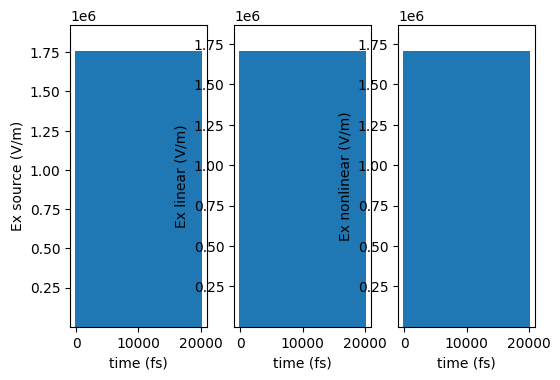

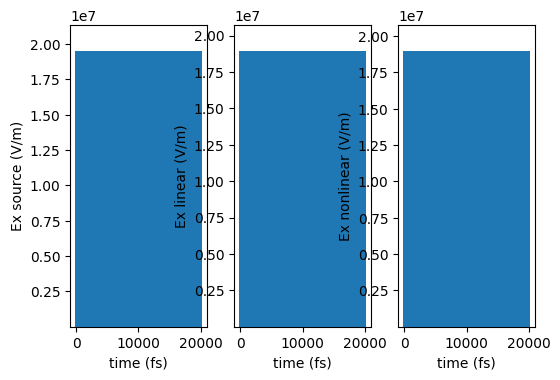

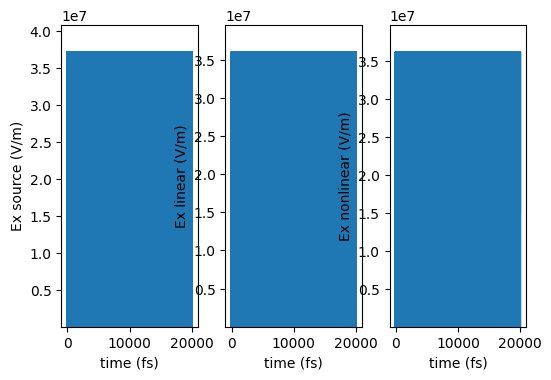

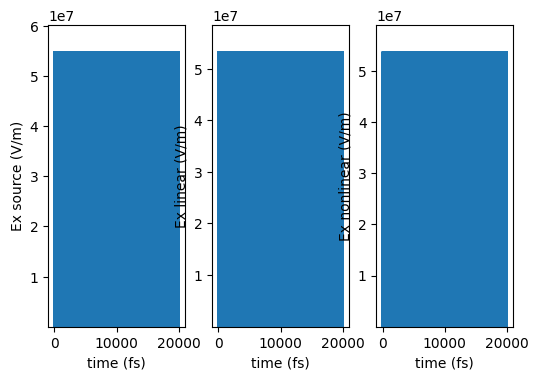

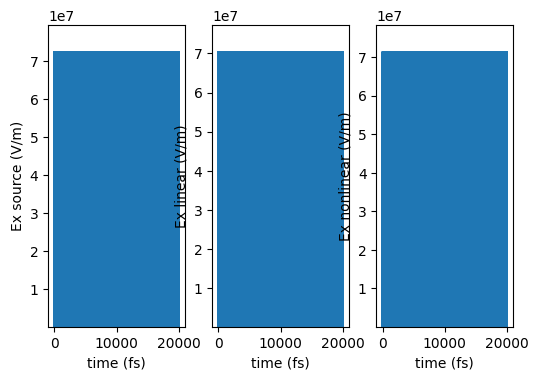

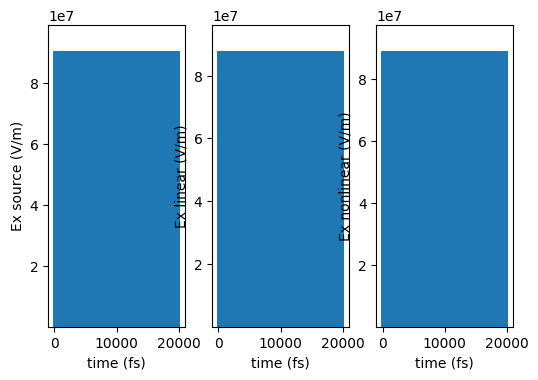

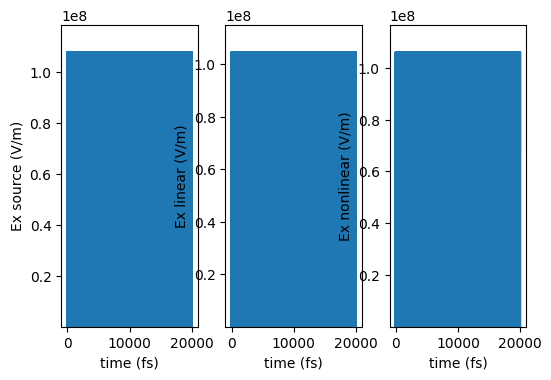

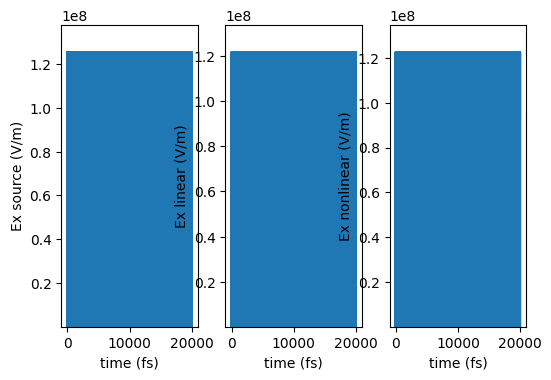

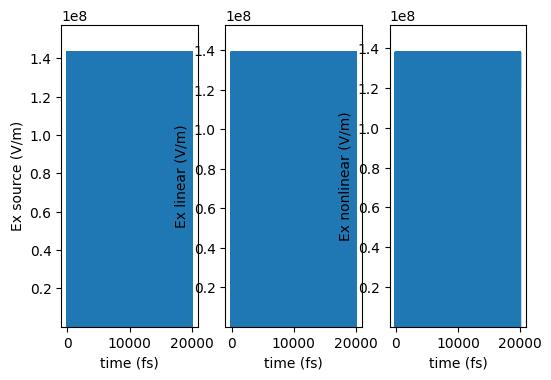

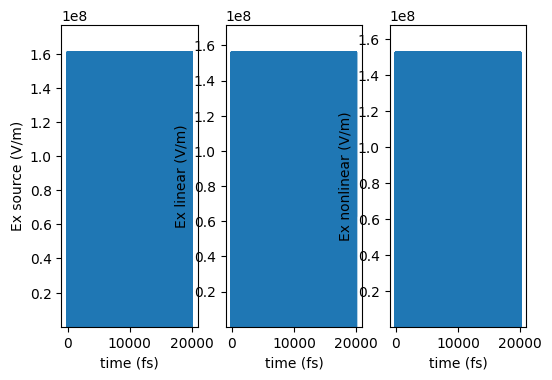

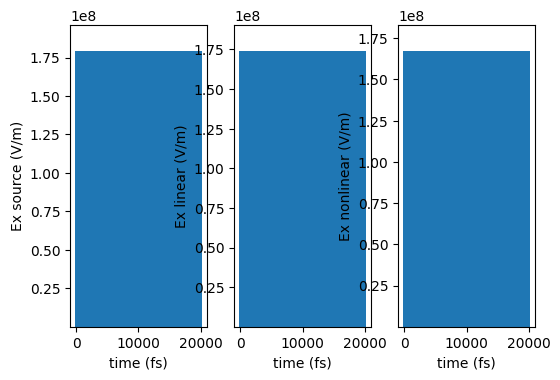

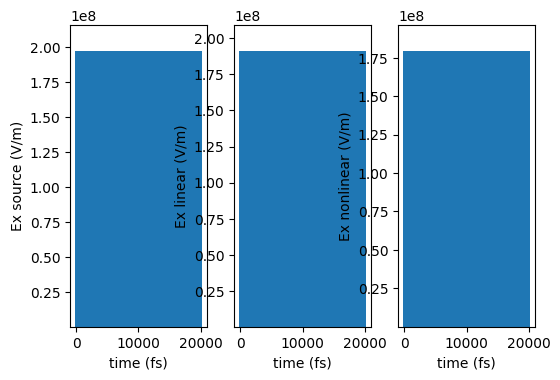

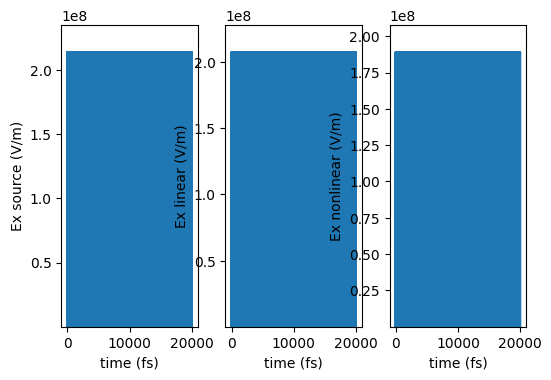

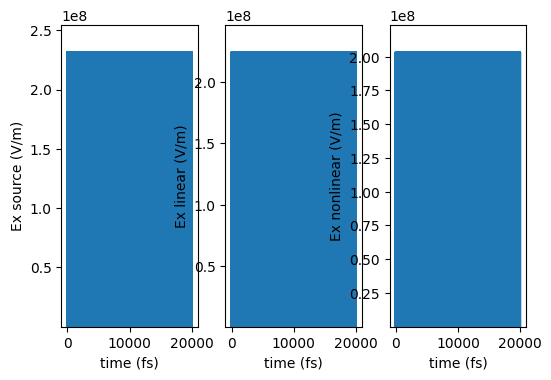

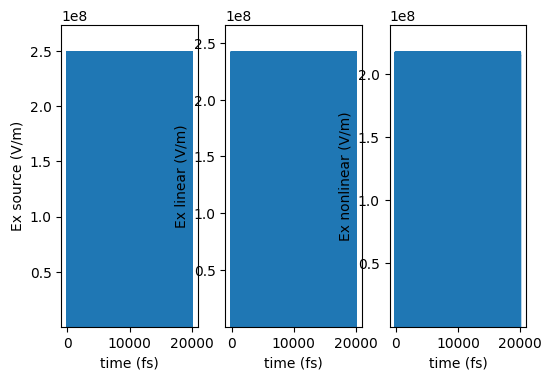

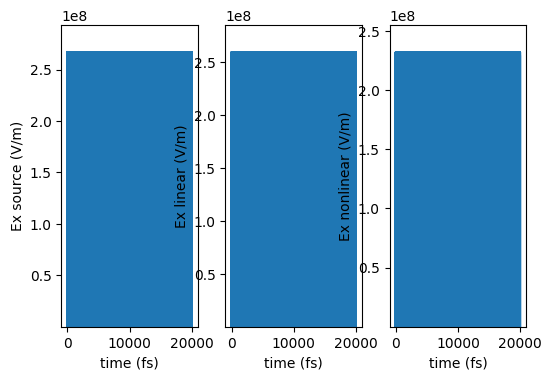

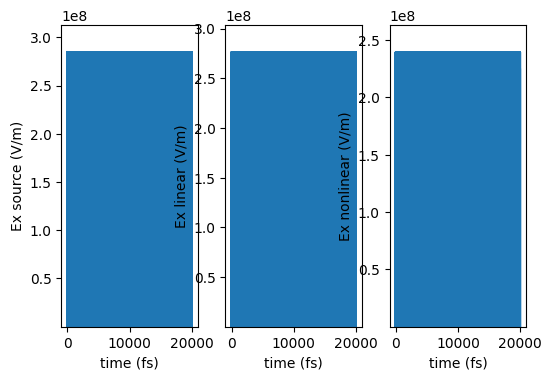

In [30]:
T_nl = np.empty(np.size(amp))
R_nl= np.empty(np.size(amp))
A_nl= np.empty(np.size(amp))
T_l= np.empty(np.size(amp))
R_l= np.empty(np.size(amp))
A_l= np.empty(np.size(amp))
E_out=np.empty(np.size(amp))
E_out2=np.empty(np.size(amp))
E_out3=np.empty(np.size(amp))
for j in range(np.size(amp)):
  print(j)
  E_out[j], E_out2[j], E_out3[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j] = nl_cw(amp[j],resolution,k,n)

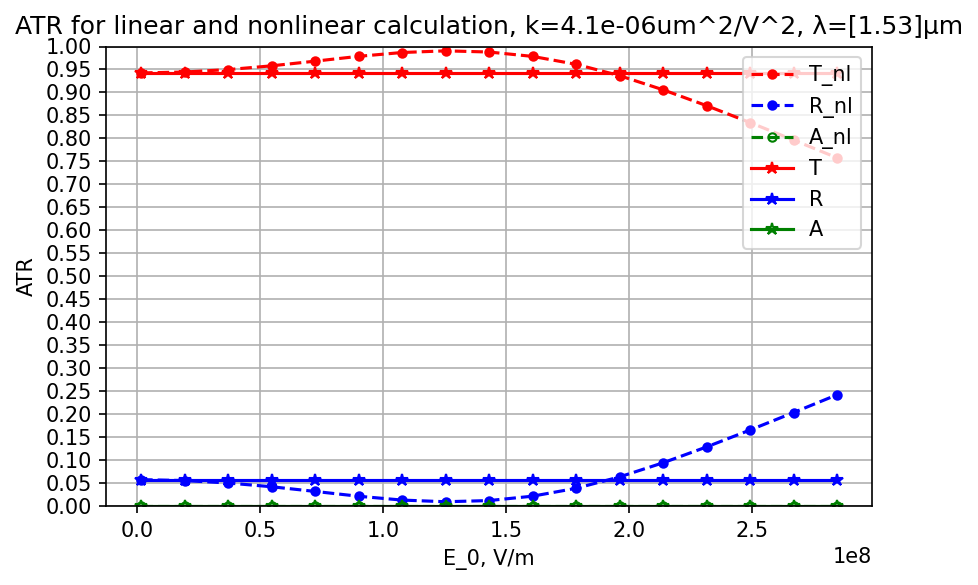

In [31]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out,T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out,R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out,A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out,T_l,'r*-',label='T')
plt.plot(E_out,R_l,'b*-',label='R')
plt.plot(E_out,A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
#plt.xticks([0.2*10**8,0.4*10**8,0.6*10**8,0.8*10**8,1*10**8,1.2*10**8,1.2*10**8,1.4*10**8,1.6*10**8,1.8*10**8,2*10**8,2.2*10**8])
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
#plt.xlim([0.1*10**8,2.4*10**8])
plt.xlabel('E_0, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_E0.txt', (E_out,T_nl,R_nl,A_nl), delimiter=',')

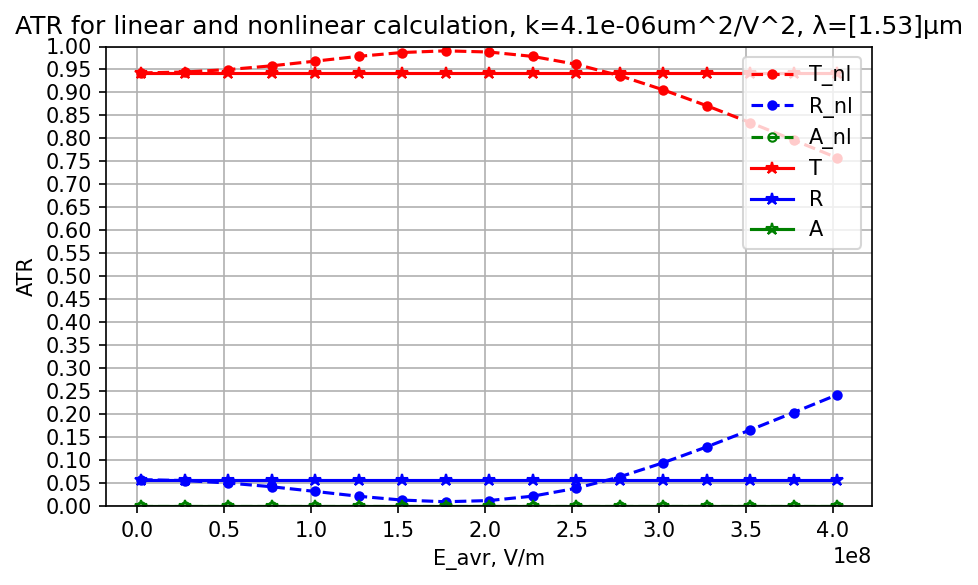

In [32]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out*np.sqrt(2),T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out*np.sqrt(2),R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out*np.sqrt(2),A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out*np.sqrt(2),T_l,'r*-',label='T')
plt.plot(E_out*np.sqrt(2),R_l,'b*-',label='R')
plt.plot(E_out*np.sqrt(2),A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
plt.xlabel('E_avr, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_Eav.txt', (E_out*np.sqrt(2),T_nl,R_nl,A_nl), delimiter=',')

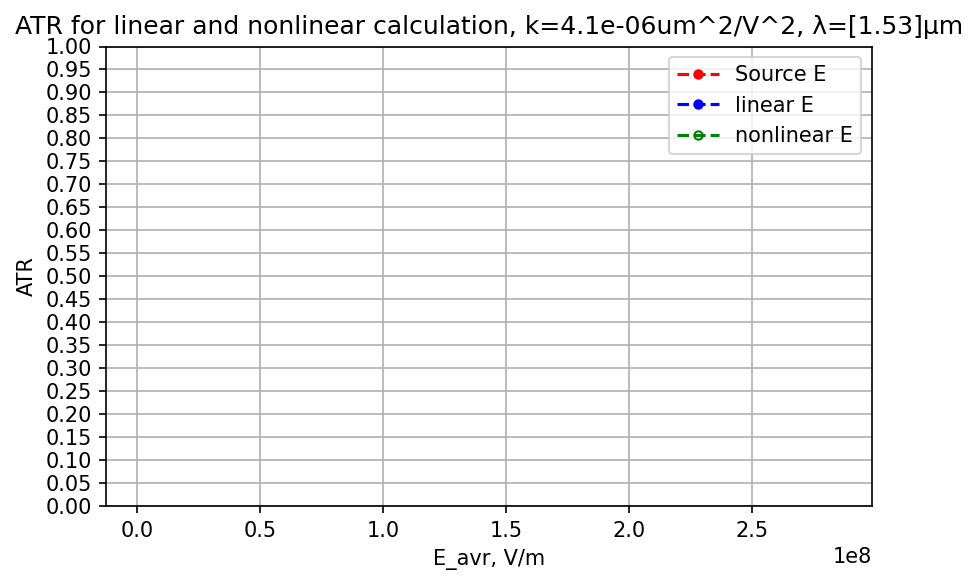

In [33]:
plt.figure(dpi=150)
plt.plot(E_out,E_out,'ro--',label='Source E',markersize=4)
plt.plot(E_out,E_out2,'bo--',label='linear E',markersize=4)
plt.plot(E_out,E_out3,'go--',label='nonlinear E',markersize=4, markerfacecolor='none')
plt.grid(True,which="both",ls="-")
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
plt.xlabel('E_avr, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()